In [1]:
import nltk
import pandas as pd
import numpy as np
import plotly.express as plot
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as mplot
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm as tqdm
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.initializers as Init
from sklearn.metrics import classification_report

In [2]:
#starting essential code
nltk_STOPWORDS = set(stopwords.words("english"))
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
df = pd.read_csv("../input/fake-news/fake_train.csv")

# EDA

In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


There are about 20k instances and 5 columns.

In [5]:
df.shape

(20800, 5)

In [6]:
df.dropna(subset=["text"], axis=0, inplace=True)

In [7]:
df.drop(["id"], axis=1, inplace=True)

In [8]:
df.shape

(20761, 4)

In [9]:
print("Unique Authors:", len(df.author.unique()))

Unique Authors: 4202


In [10]:
topAuthors = df.author.value_counts()[:10]
plot.bar(x=topAuthors.keys(), y=topAuthors.values, title="Top Authors", labels={"x":"Authors","y":"Number of News"})

In [11]:
topFakeAuthors = df[df.label == 1].author.value_counts()[:10]
plot.bar(x=topFakeAuthors.keys(), y=topFakeAuthors.values, title="Top Fake News Authors", labels={"x":"Authors","y":"Number of Fake News"})

In [12]:
topRealAuthors = df[df.label == 0].author.value_counts()[:10]
plot.bar(x=topRealAuthors.keys(), y=topRealAuthors.values, title="Top Real News Authors", labels={"x":"Authors","y":"Number of Real News"})

In [13]:
labelCount = df.label.value_counts()

plot.pie(values = labelCount.values, names=["Fake","Real"], title="Fake Vs Real")

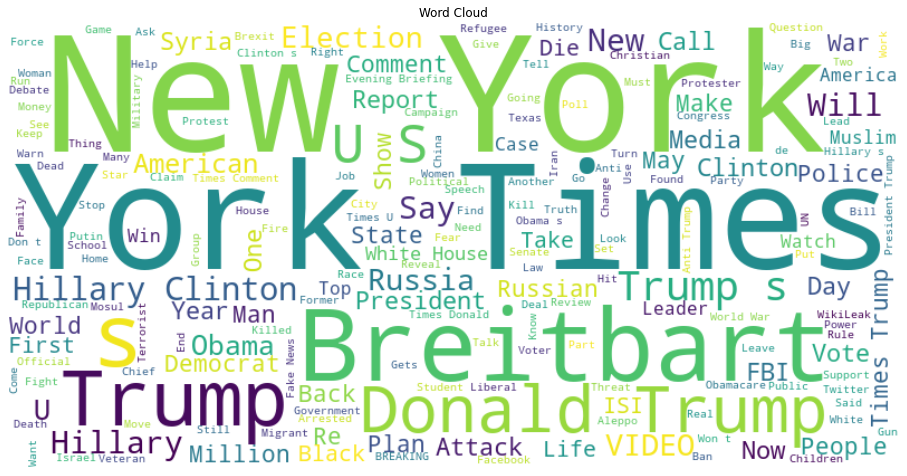

In [14]:
text = " ".join("" if pd.isnull(t) else t for t in df.title)
wc = WordCloud(width=800, height=400,stopwords=STOPWORDS, background_color="white").generate(text)
fig = mplot.figure(figsize=(16, 16))
mplot.imshow(wc, interpolation='bilinear')
mplot.axis("off")
mplot.title("Word Cloud")
mplot.show()

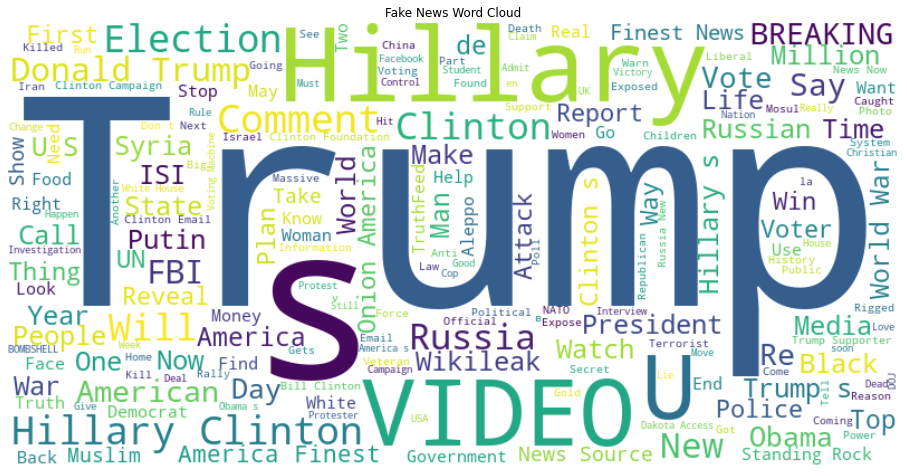

In [15]:
text = " ".join("" if pd.isnull(t) else t for t in df[df.label == 1].title)
wc = WordCloud(width=800, height=400,stopwords=STOPWORDS, background_color="white").generate(text)
fig = mplot.figure(figsize=(16, 16))
mplot.imshow(wc, interpolation='bilinear')
mplot.axis("off")
mplot.title("Fake News Word Cloud")
mplot.show()

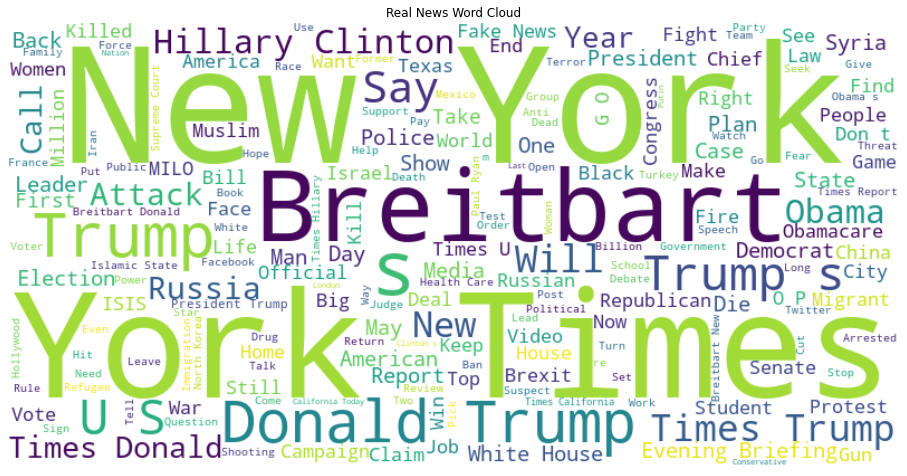

In [16]:
text = " ".join("" if pd.isnull(t) else t for t in df[df.label == 0].title)
wc = WordCloud(width=800, height=400,stopwords=STOPWORDS, background_color="white").generate(text)
fig = mplot.figure(figsize=(16, 16))
mplot.imshow(wc, interpolation='bilinear')
mplot.axis("off")
mplot.title("Real News Word Cloud")
mplot.show()

# Classification

**1. Pre Processing**

In [17]:
df = df[df.text.map(len) > 20]
df.shape

(20626, 4)

In [18]:
df["tokens"] = df.text.progress_apply(word_tokenize)

In [19]:
def toLower(tokens)->list:
    return [t.lower() for t in tokens]

df["tokens"] = df.tokens.progress_apply(toLower)

In [20]:
def removePunctuation(tokens)->list:
    return [t for t in tokens if t.isalpha()]

df["tokens"] = df.tokens.progress_apply(removePunctuation)

In [21]:
def removeStopwords(tokens) -> list:
    return [t for t in tokens if t not in nltk_STOPWORDS]

df["tokens"] = df.tokens.progress_apply(removeStopwords)

In [22]:
def removeSingleLenWords(tokens)->list:
    return [t for t in tokens if len(t) >= 2]
        

df["tokens"] = df.tokens.progress_apply(removeSingleLenWords)

In [23]:
def lematize(tokens, lematizer)->list:
    tokens = [lematizer.lemmatize(t, pos = "v") for t in tokens]
    return [lematizer.lemmatize(t, pos = "n") for t in tokens]
lemme = WordNetLemmatizer()
df["tokens"] = df.tokens.progress_apply(lambda tokens: lematize(tokens,lemme))

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
docs = df["tokens"].progress_apply(lambda tokens : ' '.join(tokens))

bagOfWords_model = vectorizer.fit(docs)
bagOfWords = bagOfWords_model.transform(docs)

In [25]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2000, n_iter=25, random_state=42)
svd_model = svd.fit(bagOfWords, df['label'])

In [26]:
data = svd_model.transform(bagOfWords)

In [27]:
(train_data, test_data, train_labels, test_labels) = train_test_split(data, df.label, test_size=0.3,random_state=563, shuffle=True)

In [28]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
NB_Model = clf.fit(train_data, train_labels)

In [29]:
print(classification_report(NB_Model.predict(test_data).round(), test_labels))

              precision    recall  f1-score   support

           0       0.43      0.66      0.52      2042
           1       0.77      0.57      0.65      4146

    accuracy                           0.60      6188
   macro avg       0.60      0.62      0.59      6188
weighted avg       0.66      0.60      0.61      6188



In [30]:
from sklearn.metrics import accuracy_score

In [31]:
from sklearn.svm import SVC
SVM = SVC(gamma='auto',probability=True,random_state=34)
SVM_model = SVM.fit(train_data,train_labels)

In [32]:
svm_predict = SVM_model.predict(test_data).round()
svm_accuracy = accuracy_score(svm_predict, test_labels)
print(classification_report(svm_predict, test_labels))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3077
           1       0.93      0.91      0.92      3111

    accuracy                           0.92      6188
   macro avg       0.92      0.92      0.92      6188
weighted avg       0.92      0.92      0.92      6188



In [33]:
from sklearn.ensemble import RandomForestClassifier
randForestCalassifier = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=23)
rf_model = randForestCalassifier.fit(train_data,train_labels)

In [34]:
rf_predict = SVM_model.predict(test_data).round()
rf_accuracy = accuracy_score(rf_predict, test_labels)
print(classification_report(rf_predict, test_labels))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3077
           1       0.93      0.91      0.92      3111

    accuracy                           0.92      6188
   macro avg       0.92      0.92      0.92      6188
weighted avg       0.92      0.92      0.92      6188



In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(n_jobs=-1, random_state=23)
lr_model = lr.fit(train_data,train_labels)

In [36]:
lr_predict = lr_model.predict(test_data).round()
lr_accuracy = accuracy_score(lr_predict, test_labels)
print(classification_report(lr_predict, test_labels))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      3092
           1       0.92      0.90      0.91      3096

    accuracy                           0.91      6188
   macro avg       0.91      0.91      0.91      6188
weighted avg       0.91      0.91      0.91      6188



In [37]:
from sklearn.ensemble import VotingClassifier
VC = VotingClassifier(estimators=[('SVM', SVM), ('Random Forest', randForestCalassifier), ('Logistic Regression', lr)],weights=[svm_accuracy,rf_accuracy,lr_accuracy], voting='hard',n_jobs=-1)
VC_model = VC.fit(train_data,train_labels)

In [38]:
vc_predict = VC_model.predict(test_data).round()
vc_accuracy = accuracy_score(vc_predict, test_labels)
print(classification_report(vc_predict, test_labels))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      3206
           1       0.91      0.93      0.92      2982

    accuracy                           0.93      6188
   macro avg       0.92      0.93      0.92      6188
weighted avg       0.93      0.93      0.93      6188



In [39]:
from sklearn.ensemble import StackingClassifier
SC = StackingClassifier(estimators=[('SVM', SVM), ('Random Forest', randForestCalassifier), ('Logistic Regression', lr)], final_estimator=lr,n_jobs=-1)
SC_model = SC.fit(train_data,train_labels)

In [40]:
sc_predict = SC_model.predict(test_data).round()
sc_accuracy = accuracy_score(sc_predict, test_labels)
print(classification_report(sc_predict, test_labels))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3149
           1       0.93      0.93      0.93      3039

    accuracy                           0.93      6188
   macro avg       0.93      0.93      0.93      6188
weighted avg       0.93      0.93      0.93      6188



In [41]:
import pickle
with open("models.bin","wb") as fp:
    pickle.dump({
        "bow":{"model":bagOfWords_model},
        "svd":{"model":svd_model},
        "lr":{"model":lr_model,"acc":lr_accuracy},
        "svm":{"model":SVM_model,"acc":svm_accuracy},
        "rf":{"model":rf_model,"acc":rf_accuracy},
        "vc":{"model":VC_model,"acc":vc_accuracy},
        "sc":{"model":SC_model,"acc":sc_accuracy}
    },fp)